<a href="https://colab.research.google.com/github/GawainGan/Stock-Markets-Analytics/blob/main/Code/Module_3_Modelling_Prediction_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install yfinance
# !pip install pandas_datareader
# !pip install fastparquet

# !pip uninstall gdown -y && pip install gdown
# !gdown -V

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### package

In [4]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt


# model and evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import export_text

# import warnings
import warnings
warnings.filterwarnings('ignore')

### data preprocessing

In [5]:
# full dataset for 33 stocks
df_full_path = '/content/drive/MyDrive/Colab Notebooks/Stock Market Analytics Zoomcamp/Module 3/stocks_df_combined_2024_05_07.parquet.brotli'
# df_full_path = '/Users/gan-m2/Stock-Markets-Analytics/Src/stocks_df_combined_2024_05_07.parquet.brotli'
df_full = pd.read_parquet(df_full_path)
df_full.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [7]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH[:5]

['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d']

In [8]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
print(TO_PREDICT)

TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
print(TO_DROP[:5])

['growth_future_5d', 'is_positive_growth_5d_future']
['Year', 'Date', 'index_x', 'index_y', 'index']


In [9]:
# define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

# TA-lib - 技术分析库，包含了常用的技术分析指标
# https://zhuanlan.zhihu.com/p/447716939
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
                        'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
                        'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
                        'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
                        'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
                        'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
                        'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
                        'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
                        'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']


TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS', 'DGS1', 'DGS5', 'DGS10']
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
print("Other features: ", OTHER)

print("number of unique tickers: ", df_full.Ticker.nunique())

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']
Other features:  ['growth_future_5d', 'is_positive_growth_5d_future']
number of unique tickers:  33


In [10]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [11]:
# truncated df_full with 25 years of data (and defined growth variables)
df_25_yr = df_full[df_full.Date>='2000-01-01']
df_25_yr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


In [12]:
# look at the features count and size:
df_25_yr[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


In [13]:
df_25_yr.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,2000-01-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.790103
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,2000-01-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.806696
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,2000-01-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.975324
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,2000-01-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.822418
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,2000-01-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.942864


# 1 - Find highest abs corr value

1. Generate dummies for month and week-of-month, eg: October-W1
2. Append to the CATEGORICAL list
3. Find the highest absolute correlation value for each feature

In [14]:
df_25_yr_copy = df_25_yr.copy()

# new column name "month-week_of_month"
# iterative the column 'Date' in the df, and get the month and week of month, then put them together and place them in the new column
df_25_yr_copy['month-week_of_month'] = df_25_yr_copy['Date'].apply(lambda x: str(x.month) + '-' + str((x.day-1)//7+1))

# print both Date and month-week_of_month columns
df_25_yr_copy[['Date', 'month-week_of_month']][:20]

,Date,month-week_of_month
3490,2000-01-03,1-1
3491,2000-01-04,1-1
3492,2000-01-05,1-1
3493,2000-01-06,1-1
3494,2000-01-07,1-1
3495,2000-01-10,1-2
3496,2000-01-11,1-2
3497,2000-01-12,1-2
3498,2000-01-13,1-2
3499,2000-01-14,1-2


In [15]:
# i want to know the unique values of the new column
month_week_of_month_list = list(df_25_yr_copy['month-week_of_month'].unique())
print("Unique values of the new column:\n", month_week_of_month_list)

Unique values of the new column:
 ['1-1', '1-2', '1-3', '1-4', '1-5', '2-1', '2-2', '2-3', '2-4', '2-5', '3-1', '3-2', '3-3', '3-4', '3-5', '4-1', '4-2', '4-3', '4-4', '5-1', '5-2', '5-3', '5-4', '5-5', '6-1', '6-2', '6-3', '6-4', '6-5', '7-1', '7-2', '7-3', '7-4', '7-5', '8-1', '8-2', '8-3', '8-4', '8-5', '9-1', '9-2', '9-3', '9-4', '9-5', '10-1', '10-2', '10-3', '10-4', '10-5', '11-1', '11-2', '11-3', '11-4', '11-5', '12-1', '12-2', '12-3', '12-4', '12-5', '4-5']


In [16]:
# add the new column to the CATEGORICAL list
CATEGORICAL.append('month-week_of_month')
print("Categorical features: ", CATEGORICAL)

Categorical features:  ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month-week_of_month']


In [17]:
# dummy variables are not generated from Date and numeric variables
df_25_yr_copy.loc[:,'Month'] = df_25_yr_copy.Month.dt.strftime('%B')
df_25_yr_copy.loc[:,'Weekday'] = df_25_yr_copy.Weekday.astype(str)

# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df_25_yr_copy[CATEGORICAL], dtype='int32')
# dummy_variables.info()

# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

print("Total number of dummy variables: ", len(DUMMIES))

Total number of dummy variables:  115


In [18]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df_25_yr_copy, dummy_variables], axis=1)
df_with_dummies[NUMERICAL+DUMMIES].info()
corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

# create a dataframe for an easy way to sort
corr_is_positive_growth_5d_future_df = pd.DataFrame(corr_is_positive_growth_5d_future)
corr_is_positive_growth_5d_future_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month-week_of_month_9-5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


,is_positive_growth_5d_future
growth_1d,-0.018940
growth_3d,-0.027915
growth_7d,-0.026683
growth_30d,-0.015110
growth_90d,-0.008799


In [19]:
print(f"The top 5 corr:\n {corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').head(5)}")

print(f"\nThe bottom 8 corr:\n {corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').tail(8)}")

The top 5 corr:
                          is_positive_growth_5d_future
DGS10                                       -0.036227
month-week_of_month_9-3                     -0.034537
gdppot_us_yoy                               -0.034185
gdppot_us_qoq                               -0.032138
DGS5                                        -0.030369

The bottom 8 corr:
                               is_positive_growth_5d_future
month-week_of_month_10-5                          0.026023
month-week_of_month_3-4                           0.026058
growth_btc_usd_30d                                0.027712
growth_future_5d                                  0.668535
is_positive_growth_5d_future                      1.000000
cdl3starsinsouth                                       NaN
cdlconcealbabyswall                                    NaN
cdlmathold                                             NaN


In [20]:
# 1. abs value for "is_positive_growth_5d_future"
abs_corr_is_positive_growth_5d_future = corr_is_positive_growth_5d_future_df.abs()
abs_corr_is_positive_growth_5d_future = abs_corr_is_positive_growth_5d_future.sort_values(by='is_positive_growth_5d_future', ascending=False)
abs_corr_is_positive_growth_5d_future.head()

,is_positive_growth_5d_future
is_positive_growth_5d_future,1.000000
growth_future_5d,0.668535
DGS10,0.036227
month-week_of_month_9-3,0.034537
gdppot_us_yoy,0.034185


In [21]:
month_list = DUMMIES[:12]
weekdays_list = DUMMIES[12:19]
month_week_of_month_list = DUMMIES[55:]

print("Month list: ", month_list)
print("\n\nWeekdays list: ", weekdays_list)
print("\n\nMonth-week_of_month list: ", month_week_of_month_list)

Month list:  ['Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September']


Weekdays list:  ['Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6']


Month-week_of_month list:  ['month-week_of_month_1-1', 'month-week_of_month_1-2', 'month-week_of_month_1-3', 'month-week_of_month_1-4', 'month-week_of_month_1-5', 'month-week_of_month_10-1', 'month-week_of_month_10-2', 'month-week_of_month_10-3', 'month-week_of_month_10-4', 'month-week_of_month_10-5', 'month-week_of_month_11-1', 'month-week_of_month_11-2', 'month-week_of_month_11-3', 'month-week_of_month_11-4', 'month-week_of_month_11-5', 'month-week_of_month_12-1', 'month-week_of_month_12-2', 'month-week_of_month_12-3', 'month-week_of_month_12-4', 'month-week_of_month_12-5', 'month-week_of_month_2-1', 'month-week_of_month_2-2', 'month-week_of_month_2-3', 'month-week_of_m

In [22]:
month_corr = abs_corr_is_positive_growth_5d_future.loc[month_list]
weekdays_corr = abs_corr_is_positive_growth_5d_future.loc[weekdays_list]
month_week_of_month_corr = abs_corr_is_positive_growth_5d_future.loc[month_week_of_month_list]

# print the top 1 correlated features for each of the 3 categories
print("Top 1 correlated features for each of the 3 categories:")
print(f"\nMonth: {month_corr.sort_values(by='is_positive_growth_5d_future', ascending=False).head(1)}")
print(f"\nWeekdays: {weekdays_corr.sort_values(by='is_positive_growth_5d_future', ascending=False).head(1)}")
print(f"\nMonth-week_of_month: {month_week_of_month_corr.sort_values(by='is_positive_growth_5d_future', ascending=False).head(1)}")

Top 1 correlated features for each of the 3 categories:

Month:                is_positive_growth_5d_future
Month_October                       0.02055

Weekdays:            is_positive_growth_5d_future
Weekday_6                      0.005664

Month-week_of_month:                          is_positive_growth_5d_future
month-week_of_month_9-3                      0.034537


According to the result, we can tell that the highest abs corr value is 0.034537.

In [24]:
# src_path = '/Users/gan-m2/Stock-Markets-Analytics/Src'
# df_with_dummies.to_csv(f'{src_path}/df_with_dummies.csv', index=False)

# 2 - Naive prediction and evaluation

In [25]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [57]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_dummies_split = temporal_split(df_with_dummies,
                                    min_date = min_date_df,
                                    max_date = max_date_df)

df_dummies_split['split'].value_counts()/len(df_dummies_split)

df_q2 = df_dummies_split.copy()

In [27]:
df_q2.groupby(['split'])['Date'].agg({'min','max','count'})

,max,min,count
split,,,
test,2024-05-07,2020-09-14,29829
train,2017-01-16,2000-01-03,123458
validation,2020-09-11,2017-01-17,29388


In [28]:
df_q2.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month-week_of_month_8-2,month-week_of_month_8-3,month-week_of_month_8-4,month-week_of_month_8-5,month-week_of_month_9-1,month-week_of_month_9-2,month-week_of_month_9-3,month-week_of_month_9-4,month-week_of_month_9-5,split
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,January,1,...,0,0,0,0,0,0,0,0,0,train
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,January,2,...,0,0,0,0,0,0,0,0,0,train
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,January,3,...,0,0,0,0,0,0,0,0,0,train
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,January,4,...,0,0,0,0,0,0,0,0,0,train


In [29]:
# features for training
df_q2[NUMERICAL+DUMMIES].head()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month-week_of_month_8-1,month-week_of_month_8-2,month-week_of_month_8-3,month-week_of_month_8-4,month-week_of_month_8-5,month-week_of_month_9-1,month-week_of_month_9-2,month-week_of_month_9-3,month-week_of_month_9-4,month-week_of_month_9-5
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0
3491,0.966220,0.957492,0.959020,1.309593,1.190225,1.979132,0.975735,0.960256,1.014543,1.105941,...,0,0,0,0,0,0,0,0,0,0
3492,1.010544,0.974839,0.955405,1.267223,1.220510,1.949679,0.987114,0.934455,0.958669,1.117215,...,0,0,0,0,0,0,0,0,0,0
3493,0.966502,0.943700,0.936170,1.227336,1.192412,1.959911,0.995824,0.959139,0.946984,1.113536,...,0,0,0,0,0,0,0,0,0,0
3494,1.013068,0.989456,0.944886,1.215405,1.203916,2.013552,1.047265,1.029454,0.988256,1.165368,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# target value
df_q2[TO_PREDICT].head()

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0
3491,0.971143,0
3492,0.929709,0
3493,0.980114,0
3494,1.007291,1


In [31]:
# generate the five new columns for the predictions, pred_0 to pred_5

# pred_0: CCI > 200
# pred_1: growth_1d > 1
# pred_2: growth_1d > 1 & growth_snp_1d > 1
# pred_3: gdppot_us_yoy <= 0.027 & fastd >=0.251
# pred_4: gdppot_us_yoy >= 0.027 & growth_wti_oil_30d <= 1.005
df_q2['pred_0'] = (df_q2['cci'] > 200).astype(int)
df_q2['pred_1'] = (df_q2['growth_1d'] > 1).astype(int)
df_q2['pred_2'] = ((df_q2['growth_1d'] > 1) & (df_q2['growth_snp500_1d'] > 1)).astype(int)
df_q2['pred_3'] = ((df_q2['gdppot_us_yoy'] <= 0.027) & (df_q2['fastd'] >= 0.251)).astype(int)
df_q2['pred_4'] = ((df_q2['gdppot_us_yoy'] >= 0.027) & (df_q2['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [32]:
naive_prediction_pred_3_4 = df_q2[df_q2["split"] == 'test'][['pred_3', 'pred_4', 'is_positive_growth_5d_future']]
naive_prediction_pred_3_4.head()

,pred_3,pred_4,is_positive_growth_5d_future
8697,1,0,0
8698,1,0,0
8699,1,0,0
8700,1,0,1
8701,1,0,1


In [33]:
# Note: You should notice that one of the predictions doesn't have any positive predictions on TEST dataset
print(f"Number of unique value in pred_3 is: {naive_prediction_pred_3_4['pred_3'].nunique()}")
print(f"Number of unique value in pred_4 is: {naive_prediction_pred_3_4['pred_4'].nunique()}")

Number of unique value in pred_3 is: 2
Number of unique value in pred_4 is: 1


In [34]:
# take the 'is_positive_growth_5d_future' column as the true value
# take the 'pred_3' and 'pred_4' columns as the predicted value
# calculate the precision score for each prediction
precision_pred_3 = precision_score(naive_prediction_pred_3_4['is_positive_growth_5d_future'], naive_prediction_pred_3_4['pred_3'], zero_division=1)

print(f"Precision score for pred_3: {round(precision_pred_3,3)}")

Precision score for pred_3: 0.555


### Explain why this can happen (the pred_4 doesn't have any positive prediction on TEST set) even if there are no errors in the data features.

In [35]:
print(f"The number of unique value in pred_4 in train set is {df_q2[df_q2['split'] == 'train']['pred_4'].nunique()}, time range is {df_q2[df_q2['split'] == 'train']['Date'].min()} to {df_q2[df_q2['split'] == 'train']['Date'].max()}")
print(f"The number of unique value in pred_4 in validation set is {df_q2[df_q2['split'] == 'validation']['pred_4'].nunique()}, time range is {df_q2[df_q2['split'] == 'validation']['Date'].min()} to {df_q2[df_q2['split'] == 'validation']['Date'].max()}")
print(f"The number of unique value in pred_4 in test set is {df_q2[df_q2['split'] == 'test']['pred_4'].nunique()}, time range is {df_q2[df_q2['split'] == 'test']['Date'].min()} to {df_q2[df_q2['split'] == 'test']['Date'].max()}")

The number of unique value in pred_4 in train set is 2, time range is 2000-01-03 00:00:00 to 2017-01-16 00:00:00
The number of unique value in pred_4 in validation set is 1, time range is 2017-01-17 00:00:00 to 2020-09-11 00:00:00
The number of unique value in pred_4 in test set is 1, time range is 2020-09-14 00:00:00 to 2024-05-07 00:00:00


In [36]:
# 检查 growth_wti_oil_30d 的 medium value from train, validation and test set
print(f"The statistics of growth_wti_oil_30d in train set is \n{df_q2[df_q2['split'] == 'train']['growth_wti_oil_30d'].describe()}")
print(f"\nThe statistics of growth_wti_oil_30d in validation set is \n{df_q2[df_q2['split'] == 'validation']['growth_wti_oil_30d'].describe()}")
print(f"\nThe statistics of growth_wti_oil_30d in test set is \n{df_q2[df_q2['split'] == 'test']['growth_wti_oil_30d'].describe()}")

The statistics of growth_wti_oil_30d in train set is 
count    117403.000000
mean          1.010806
std           0.123401
min           0.528531
25%           0.939119
50%           1.014989
75%           1.085745
max           1.541495
Name: growth_wti_oil_30d, dtype: float64

The statistics of growth_wti_oil_30d in validation set is 
count    29094.000000
mean         1.011999
std          0.254522
min         -0.978209
25%          0.947459
50%          1.021004
75%          1.084035
max          3.725275
Name: growth_wti_oil_30d, dtype: float64

The statistics of growth_wti_oil_30d in test set is 
count    29498.000000
mean         1.028939
std          0.115884
min          0.775530
25%          0.942308
50%          1.027873
75%          1.109100
max          1.484816
Name: growth_wti_oil_30d, dtype: float64


### Explanation of pred_4's Lack of Positive Predictions in Validation and Test Sets

**Economic and Market Conditions**:
- The condition `gdppot_us_yoy >= 0.027` signifies a relatively high year-over-year GDP growth rate of 2.7% or more.
- The condition `growth_wti_oil_30d <= 1.005` indicates that the 30-day growth rate of WTI oil prices should be less than or equal to 0.5%, suggesting very stable or slightly increasing oil prices.

**Dataset Split and Distribution**:
- The data is split into training, validation, and test sets in a 0.7/0.15/0.15 ratio, with the earliest date being 2000-01-03 and the latest date being 2024-05-07.
- Only the training set has `pred_4` meeting its conditions, resulting in two unique values (0 and 1). In contrast, both the validation and test sets have `pred_4` with only one unique value (0).

**Macroeconomic Perspective**:
1. **GDP Growth**:
   - From 2000 to 2024, there have been periods in the US where the GDP growth rate exceeded 2.7%.
2. **WTI Oil Price Growth**:
   - A 30-day growth rate of WTI oil prices less than or equal to 0.5% indicates a stable or slightly increasing oil price.

**Conflict Between Conditions**:
- High GDP growth often correlates with rising oil prices due to increased demand, which makes it unlikely for both conditions (`gdppot_us_yoy >= 0.027` and `growth_wti_oil_30d <= 1.005`) to be met simultaneously.
- This inherent conflict means that periods of rapid economic growth are usually accompanied by rising oil prices, thus failing the condition for stable oil prices.

**Analysis of Data Statistics**:
- In the training set, the economic conditions were such that the GDP growth was moderate, and WTI oil prices were relatively stable, allowing `pred_4` to have two unique values.
- Post-2017, the US economy experienced significant fluctuations, leading to larger variations in GDP growth and oil prices, which is reflected in the validation and test sets.

**Growth WTI Oil 30d Statistics**:
- **Training Set**:
  - Mean: 1.010806
  - Median (50%): 1.014989
- **Validation Set**:
  - Mean: 1.011999
  - Median (50%): 1.021004
- **Test Set**:
  - Mean: 1.028939
  - Median (50%): 1.027873

The statistics show that the median value of `growth_wti_oil_30d` is consistently above 1.005 in both validation and test sets, indicating that the oil price growth condition is rarely met in these sets. This supports the observation that `pred_4` is always 0 in these sets.

### Conclusion

The stringent conditions set for `pred_4` (high GDP growth and stable oil prices) are rarely met simultaneously due to their conflicting nature. This explains why `pred_4` has no positive predictions in the validation and test sets, even though the training set includes periods where these conditions were satisfied. The economic and market conditions during the validation and test periods did not align to meet both criteria, resulting in `pred_4` having only one unique value (0).

# 3 - Decision tree model prediction and evaluation

In [37]:
# new df, filter from the df_q2, from pred_0 to pred_4
pred_df = df_q2[['Date', 'split', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'is_positive_growth_5d_future']]
pred_df.head()

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future
3490,2000-01-03,train,0,0,0,0,0,0
3491,2000-01-04,train,0,0,0,0,0,0
3492,2000-01-05,train,0,1,1,0,0,0
3493,2000-01-06,train,0,0,0,0,0,0
3494,2000-01-07,train,0,1,1,0,0,1


In [38]:
len(pred_df) == len(df_q2)

True

In [39]:
df_q3 = df_with_dummies.copy()
# replace the inf and -inf with NaN
df_q3.replace([np.inf, -np.inf], np.nan, inplace=True)
# fillna to 0
df_q3.fillna(0, inplace=True)
# take the sets for model fitting
df_q3_model_fit = df_q3[df_q3['split'] != 'test']

# fit the model
clf_10 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_10.fit(df_q3_model_fit[NUMERICAL+DUMMIES], df_q3_model_fit['is_positive_growth_5d_future'])

DecisionTreeClassifier(max_depth=10, random_state=42)

In [40]:
# predict whole set, and place the predicted value to the new column 'pred_5' in pred_df
pred_df['pred_5'] = clf_10.predict(df_q3[NUMERICAL+DUMMIES])
pred_df.head()

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5
3490,2000-01-03,train,0,0,0,0,0,0,1
3491,2000-01-04,train,0,0,0,0,0,0,1
3492,2000-01-05,train,0,1,1,0,0,0,1
3493,2000-01-06,train,0,0,0,0,0,0,1
3494,2000-01-07,train,0,1,1,0,0,1,1


In [41]:
pred_df['pred_5'].value_counts()

pred_5
1    151681
0     30994
Name: count, dtype: int64

In [42]:
# Filtering the dataframe where pred_5 matches is_positive_growth_5d_future, on test set
test_set = pred_df[pred_df['split'] == 'test']
# matching pred_5 and is_positive_growth_5d_future
test_set_pred5_match = test_set[test_set['pred_5'] == test_set['is_positive_growth_5d_future']]
test_set_pred5_match.head()

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5
8700,2020-09-17,test,0,0,0,1,0,1,1
8701,2020-09-18,test,0,0,0,1,0,1,1
8702,2020-09-21,test,0,1,0,1,0,1,1
8704,2020-09-23,test,0,0,0,1,0,1,1
8705,2020-09-24,test,0,1,1,1,0,1,1


In [43]:
def return_match_bool(row):
    # go through the columns from pred_0 to pred_4
    # if the value is opposite to the value in pred_5, then return True
    # else return False
    return all([row[f'pred_{i}'] != row['pred_5'] for i in range(5)])
# apply the function to the dataframe
test_set_pred5_match['match'] = test_set_pred5_match.apply(return_match_bool, axis=1)
test_set_pred5_match.head()

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5,match
8700,2020-09-17,test,0,0,0,1,0,1,1,False
8701,2020-09-18,test,0,0,0,1,0,1,1,False
8702,2020-09-21,test,0,1,0,1,0,1,1,False
8704,2020-09-23,test,0,0,0,1,0,1,1,False
8705,2020-09-24,test,0,1,1,1,0,1,1,False


In [44]:
# print the row where the match is True
test_set_pred5_match[test_set_pred5_match['match'] == True]

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5,match
4,2022-05-23,test,0,0,0,0,0,1,1,True


In [45]:
# count the match
match_count = test_set_pred5_match['match'].sum()
match_count

1

In [ ]:
# print all row of test_set_pred5_match
# test_set_pred5_match.to_csv(f'{src_path}/test_set_pred5_match.csv', index=False)

# 4 Model tuning

In [47]:
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_5d_future'

In [71]:
# filter train, val and test set
df_q4 = df_q3.copy()

# replace the inf and -inf with NaN
df_q4 = df_q4.replace([np.inf, -np.inf], np.nan)
# fillna to 0
df_q4 = df_q4.fillna(0)

X_train = df_q4[df_q4['split'] == 'train'][features_list]
y_train = df_q4[df_q4['split'] == 'train'][to_predict]

# Create a validation set X_valid
X_valid = df_q4[df_q4['split'] == 'validation'][features_list]
y_valid = df_q4[df_q4['split'] == 'validation'][to_predict]

# Leave the test set X_test unchanged
X_test = df_q4[df_q4['split'] == 'test'][features_list]
y_test = df_q4[df_q4['split'] == 'test'][to_predict]

X_all = df_q4[features_list]
y_all = df_q4[to_predict]

In [72]:
print(y_train.head())

X_train.head()

3490    0
3491    0
3492    0
3493    0
3494    1
Name: is_positive_growth_5d_future, dtype: int64


,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month-week_of_month_8-1,month-week_of_month_8-2,month-week_of_month_8-3,month-week_of_month_8-4,month-week_of_month_8-5,month-week_of_month_9-1,month-week_of_month_9-2,month-week_of_month_9-3,month-week_of_month_9-4,month-week_of_month_9-5
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0
3491,0.966220,0.957492,0.959020,1.309593,1.190225,1.979132,0.975735,0.960256,1.014543,1.105941,...,0,0,0,0,0,0,0,0,0,0
3492,1.010544,0.974839,0.955405,1.267223,1.220510,1.949679,0.987114,0.934455,0.958669,1.117215,...,0,0,0,0,0,0,0,0,0,0
3493,0.966502,0.943700,0.936170,1.227336,1.192412,1.959911,0.995824,0.959139,0.946984,1.113536,...,0,0,0,0,0,0,0,0,0,0
3494,1.013068,0.989456,0.944886,1.215405,1.203916,2.013552,1.047265,1.029454,0.988256,1.165368,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Initialize variables to track the best max_depth and highest precision score
testing_set_score = {}
# validation_set_score = {}

# Iterate through max_depth values from 1 to 20
for max_depth in range(1, 21):
    sub_list_on_test = []
    # sub_list_on_val = []
    print(f"...Training model with max_depth={max_depth}...")

    # Initialize the Decision Tree Classifier with the current max_depth and random_state=42
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # Fit the model on TRAIN+VALIDATION sets
    clf.fit(X_train, y_train)

    # Predict on the TEST set
    y_pred_on_test = clf.predict(X_test)
    # Calculate the precision & accuracy score on the TEST set
    precision_on_test = precision_score(y_test, y_pred_on_test)
    accuracy_on_test = accuracy_score(y_test, y_pred_on_test)
    sub_list_on_test.append(precision_on_test)
    sub_list_on_test.append(accuracy_on_test)
    # append the precision score to the testing_set_score dictionary, the key is the max_depth
    testing_set_score[max_depth] = sub_list_on_test

    # # Predict on the VALIDATION set
    # y_pred_on_val = clf.predict(X_valid)
    # # Calculate the precision score on the VALIDATION set
    # precision_on_val = precision_score(y_valid, y_pred_on_val)
    # accuracy_on_val = accuracy_score(y_valid, y_pred_on_val)
    # sub_list_on_val.append(precision_on_val)
    # sub_list_on_val.append(accuracy_on_val)
    # # append the precision score to the validation_set_score dictionary, the key is the max_depth
    # validation_set_score[max_depth] = sub_list_on_val

    # Print the rules of the decision tree for the first 3 levels
    tree_rules = export_text(clf, feature_names=features_list, max_depth=3)
    print(f"Tree rules for max_depth={max_depth}:\n {tree_rules} \n")

    if max_depth == 20:
        print(f"End")

...Training model with max_depth=1...
Tree rules for max_depth=1:
 |--- gdppot_us_yoy <= 0.03
|   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- class: 0
 

...Training model with max_depth=2...
Tree rules for max_depth=2:
 |--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- class: 0
|   |--- fastd >  0.25
|   |   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- growth_wti_oil_30d <= 1.00
|   |   |--- class: 1
|   |--- growth_wti_oil_30d >  1.00
|   |   |--- class: 0
 

...Training model with max_depth=3...
Tree rules for max_depth=3:
 |--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- growth_brent_oil_90d <= 1.06
|   |   |   |--- class: 0
|   |   |--- growth_brent_oil_90d >  1.06
|   |   |   |--- class: 1
|   |--- fastd >  0.25
|   |   |--- growth_gold_365d <= 1.53
|   |   |   |--- class: 1
|   |   |--- growth_gold_365d >  1.53
|   |   |   |--- class: 0
|--- gdppot_us_yoy >  0.03
|   |--- growth_wti_oil_30d <= 1.00
|   |   |--- growth_dji_90d <= 0.97
|   |  

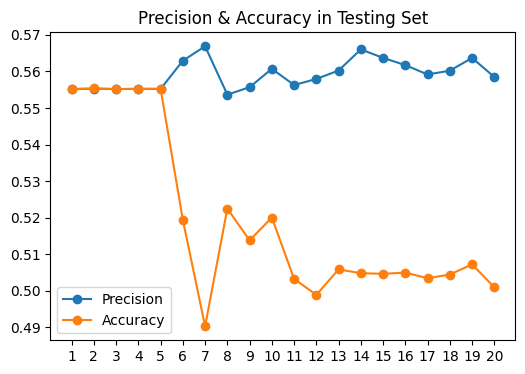

In [81]:
# [0]:precision, [1]:accuracy
# plot the precision and accuracy score for both test and validation set
# plot testing set first
plt.figure(figsize=(6, 4))
plt.plot(list(testing_set_score.keys()), [v[0] for v in testing_set_score.values()], label='Precision', marker='o')
plt.plot(list(testing_set_score.keys()), [v[1] for v in testing_set_score.values()], label='Accuracy', marker='o')
# x ticks must be integers
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title("Precision & Accuracy in Testing Set")
plt.show();

In [83]:
# print the precision value for the 7th max_depth
print(f"The highest precision score for max_depth=7 is: {round(testing_set_score[7][0],3)}")

The highest precision score for max_depth=7 is: 0.567


In [75]:
# # plot validation set
# plt.figure(figsize=(6, 4))
# plt.plot(list(validation_set_score.keys()), [v[0] for v in validation_set_score.values()], label='Validation Precision', marker='o')
# plt.plot(list(validation_set_score.keys()), [v[1] for v in validation_set_score.values()], label='Validation Accuracy', marker='o')
# # x ticks must be integers
# plt.xticks(np.arange(1, 21, 1))
# plt.legend()
# plt.show();

In [67]:
best_max_depth =7
# Fit the model with the best_max_depth on the entire dataset (TRAIN+VALIDATION+TEST)
clf_best = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
clf_best.fit(X_all, y_all)

# Make predictions on all records and add the new prediction pred6_clf_best to the dataframe
pred_df['pred6_clf_best'] = clf_best.predict(X_all)

# Compare the precision score of the tuned decision tree with previous predictions
precision_best = precision_score(y_all, pred_df['pred6_clf_best'])

# Output the precision score of the tuned decision tree
precision_best

0.5727327479633563